In [1]:
# Load all helper functions
%run -i '../util/helper.py'

## Load and Split Data

In [73]:
# load dataset
df  = pd.read_csv('../Dataset/brazilian_ecommerce_encoded_scaled.csv')

#split dataset in features and target variable
y = df["is_delayed"]
X = df.drop(["is_delayed"], axis=1, inplace=False)

In [74]:
# split X and y into training and testing sets
X_dev, X_test, y_dev, y_test = train_test_split(X, y, random_state=random_state, test_size=0.2, stratify=y)

In [75]:
print(X_dev.shape)
print(X_test.shape)

(92506, 29)
(23127, 29)


### Since the data is highly imbalanced (as seen below), I'll be using grid search to determine the optimal value of weights to be assigned to each class. Merely using class_weight='balanced' in the LogisticRegression Classifier is not able to make the model converge.

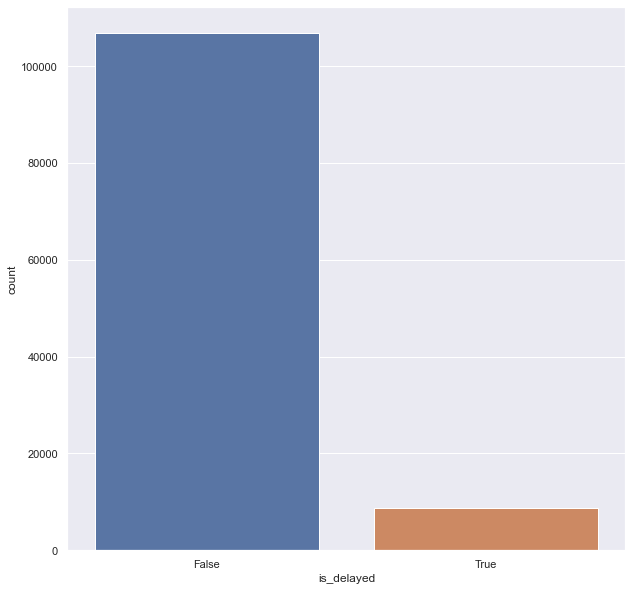

In [76]:
plt.rcParams["figure.figsize"] = (10, 10)
sns.set_theme(style="darkgrid")
g = sns.countplot(x = df['is_delayed'])

# Hyperparameter Tuning

## Stratified Sampling

### GridSearch

In [77]:
penalty = ['l2', 'none', 'elasticnet']
C = np.logspace(-1, 1, 5)
solver = ['newton-cg', 'sag']
# num_weights = np.linspace(0.0,0.99,50)
# weights = [{0:x, 1:1.0-x} for x in num_weights]
start3 = time()

parameter_grid = {'classifier__penalty': penalty,
                  'classifier__C': C,
                  'classifier__solver':solver}

pipe_logistic_tune = Pipeline([('classifier', LogisticRegression(random_state=random_state, class_weight='balanced'))])

pipe_logistic = make_pipeline(GridSearchCV(pipe_logistic_tune,
                                      param_grid=parameter_grid,
                                      return_train_score=True,
                                      cv=StratifiedKFold(n_splits=10, shuffle=False),
                                      n_jobs=-1, 
                                      scoring=['recall','f1'],
                                      refit='f1',
                                      verbose = 5))
pipe_logistic.fit(X_dev, np.ravel(y_dev))
end3 = time()
print("Logistic Regression model takes " + str(end3-start3) + "seconds")
print("The performance of the Logistic Regression model on test data is ", pipe_logistic.score(X_test, y_test))
grid_search_logistic = pipe_logistic.named_steps["gridsearchcv"]
print("The Logistic Regression model Best hyperparameters are {}".format(grid_search_logistic.best_params_))


Fitting 10 folds for each of 30 candidates, totalling 300 fits
Logistic Regression model takes 50.8274040222168seconds
The performance of the Logistic Regression model on test data is  0.36427076064200975
The Logistic Regression model Best hyperparameters are {'classifier__C': 0.1, 'classifier__penalty': 'l2', 'classifier__solver': 'newton-cg'}


## Evaluate on the Test Set

In [78]:
# weights = np.linspace(0.0,0.99,50)
# [{0:x, 1:1.0-x} for x in weights]

In [79]:
logistic_prediction = pipe_logistic.predict(X_test)

print('Accuracy: {}'.format(accuracy_score(y_test, logistic_prediction)))
print('Recall: {}'.format(recall_score(y_test, logistic_prediction)))
print('Precision: {}'.format(precision_score(y_test, logistic_prediction)))
print('F-1 Score: {}'.format(f1_score(y_test, logistic_prediction)))

recall, precision = recall_score(y_test, logistic_prediction), precision_score(y_test, logistic_prediction)

Accuracy: 0.8030440610541791
Recall: 0.7487091222030982
Precision: 0.24068609369236443
F-1 Score: 0.36427076064200975


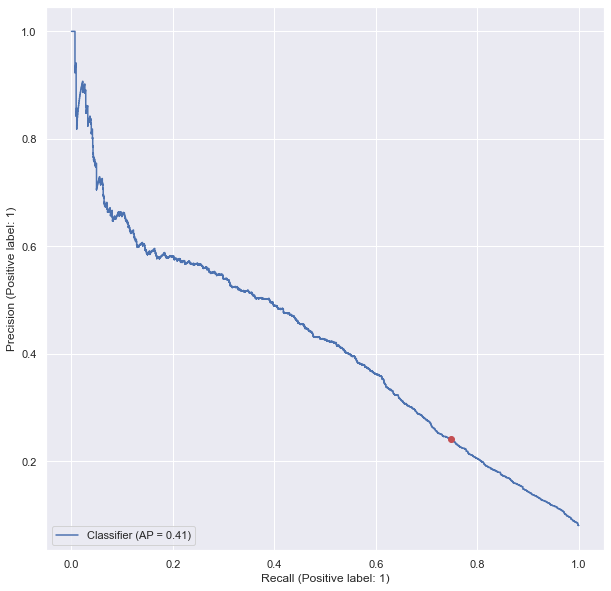

In [80]:
probs = pipe_logistic.predict_proba(X_test)[:,1]
PrecisionRecallDisplay.from_predictions(y_test, probs)
plt.plot(recall,precision,'ro');

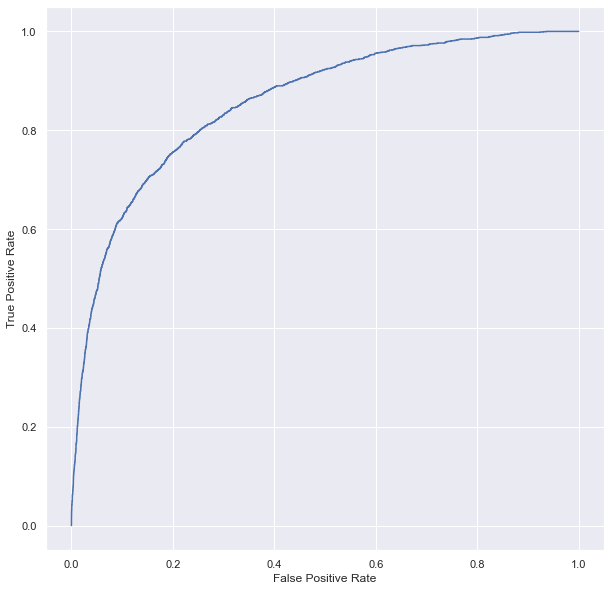

In [81]:
fpr, tpr, thresholds = roc_curve(y_test, probs, pos_label = 1)
disp = RocCurveDisplay(fpr = fpr, tpr = tpr)
disp.plot()

In [ ]:
filename = '../model/logistic_stratified.sav'
pickle.dump(pipe_logistic, open(filename, 'wb'))

## Downsampling

In [ ]:
rus = RandomUnderSampler(replacement=False, random_state=random_state)
X_dev_us, y_dev_us = rus.fit_resample(X_dev, y_dev)

## GridSearch

In [ ]:
penalty = ['l2', 'none']
C = [np.logspace(-4, 4, 20)]
solver = ['newton-cg', 'lbfgs', 'sag', 'saga']
start3 = time()

parameter_grid = {'classifier__penalty' :penalty,
                  'classifier__C': C,
                  'classifier__solver':solver}

pipe_logistic_tune = Pipeline([('classifier', LogisticRegression(random_state=random_state))])

pipe_logistic_rus = make_pipeline(GridSearchCV(pipe_logistic_tune,
                                      param_grid=parameter_grid,
                                      return_train_score=True,
                                      cv=StratifiedKFold(n_splits=10,shuffle=False),
                                      n_jobs=-1, 
                                      scoring=['recall','f1'],
                                      refit='f1'))
pipe_logistic_rus.fit(X_dev_us, np.ravel(y_dev_us))
end3 = time()
print("Logistic Regression model takes " + str(end3-start3) + "seconds")
print("The performance of the Logistic Regression model on test data is ", pipe_logistic_rus.score(X_test, y_test))
grid_search_logistic = pipe_logistic_rus.named_steps["gridsearchcv"]
print("The Logistic Regression model Best hyperparameters are {}".format(grid_search_logistic.best_params_))


## Evaluate on the Test Set

In [ ]:
logistic_prediction = pipe_logistic_rus.predict(X_test)

print('Accuracy: {}'.format(accuracy_score(y_test, logistic_prediction)))
print('Recall: {}'.format(recall_score(y_test, logistic_prediction)))
print('Precision: {}'.format(precision_score(y_test, logistic_prediction)))
print('F-1 Score: {}'.format(f1_score(y_test, logistic_prediction)))

recall, precision = recall_score(y_test, logistic_prediction), precision_score(y_test, logistic_prediction)

NameError: name 'pipe_logistic' is not defined

In [ ]:
probs = pipe_logistic.predict_proba(X_test)[:,1]
PrecisionRecallDisplay.from_predictions(y_test, probs)
plt.plot(recall,precision,'ro');

In [ ]:
fpr, tpr, thresholds = roc_curve(y_test, probs, pos_label = 1)
disp = RocCurveDisplay(fpr = fpr, tpr = tpr)
disp.plot()

In [ ]:
filename = '../Model/logistic_downsampling.sav'
pickle.dump(pipe_logistic_rus, open(filename, 'wb'))